# Göğüs Röntgeni Görüntü İşleme Projesi

Bu projede **ChestX-ray8** veri setinden alınan göğüs röntgeni görüntüleri üzerinde çeşitli **ön işleme (pre-processing), eşikleme (thresholding)** ve **morfolojik işlemler (post-processing)** uygulanacaktır. Amacımız, akciğer bölgesi veya ilgi alanını belirleyebilmek, olası gürültü unsurlarını azaltmak ve **connected component (bağlantı bileşen) analizi** ile maskeleme yaparak **akciğer segmentasyonu** benzeri bir iş akışı kurgulamaktır. Proje kapsamında temel olarak:

- Kütüphanelerin yüklenmesi
- Veri setinin indirilmesi ve temel incelemesi
- Rastgele seçilmiş 9 görüntünün işlenmesi (istatistiksel özelliklerin hesaplanması, histogram analizi)
- Kenarlardan kırpma (crop)
- Kontrast iyileştirme (Contrast Stretching, Histogram Equalization, Gamma Correction)
- Gürültü azaltma (Median/Gaussian blur)
- Thresholding (Otsu vb. yöntemlerle)
- Morfolojik işlemler (opening/closing)
- Connected Component Labeling (bölge etiketleme)
- Son olarak filtrelenmiş maskenin orijinal görüntüye uygulanması (maskeleme)

Aşağıdaki kod hücrelerinde tüm adımlar detaylı şekilde yorumlanarak verilmiştir.


In [1]:
#############################################################################
# 1) Kütüphanelerin Yüklenmesi
#############################################################################
print("PROJE ADIMI 1: İhtiyaç duyulan kütüphanelerin yüklenmesi:")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # OpenCV
import os
from skimage import exposure
from skimage.filters import try_all_threshold, threshold_otsu
from skimage.morphology import disk, opening, closing
from scipy.ndimage import zoom
%matplotlib inline
sns.set()

print("Tüm kütüphaneler başarıyla yüklendi.\n")


#############################################################################
# 2) ChestX-ray8 veri setinin küçük bir örneğini içeren reponun klonlanması
#    ve verinin incelenmesi
#############################################################################
print("PROJE ADIMI 2: ChestX-ray8 veri setine ait mini reponun klonlanması:")

!git clone https://github.com/hardik0/AI-for-Medicine-Specialization
%cd AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/
print("Repo klonlama işlemi tamamlandı.\n")

print("Veri çerçevesini (DataFrame) okuyarak temel bilgileri inceleyelim.")
print("CSV dosyası okunuyor...")

train_df = pd.read_csv("nih/train-small.csv")
print(f"\nVeri setinde toplam {train_df.shape[0]} satır ve {train_df.shape[1]} sütun bulunuyor.\n")

print("DataFrame ilk 5 satırını görelim:")
display(train_df.head())

print("\nDataFrame sütunlarına göz atalım:")
display(train_df.info())

print("\nDataFrame içerisinde yer alan PatientId sütunundaki toplam ve eşsiz hasta sayısı:")
print(f"Toplam hasta ID sayısı {train_df['PatientId'].count()}, bunlardan benzersiz ID sayısı {train_df['PatientId'].value_counts().shape[0]}\n")

print("Veri setinde tanı sütunlarının dağılımına bakalım:")
columns = list(train_df.keys())
columns.remove('Image')
columns.remove('PatientId')
for col in columns:
    print(f"{col} sınıfı {train_df[col].sum()} örnek içeriyor")

print("\nGörüntü işleme aşamasına geçiliyor...")

PROJE ADIMI 1: İhtiyaç duyulan kütüphanelerin yüklenmesi:
Tüm kütüphaneler başarıyla yüklendi.

PROJE ADIMI 2: ChestX-ray8 veri setine ait mini reponun klonlanması:
fatal: destination path 'AI-for-Medicine-Specialization' already exists and is not an empty directory.
/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis
Repo klonlama işlemi tamamlandı.

Veri çerçevesini (DataFrame) okuyarak temel bilgileri inceleyelim.
CSV dosyası okunuyor...

Veri setinde toplam 1000 satır ve 16 sütun bulunuyor.

DataFrame ilk 5 satırını görelim:


Image  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0  00008270_015.png            0             0              0      0   
1  00029855_001.png            1             0              0      0   
2  00001297_000.png            0             0              0      0   
3  00012359_002.png            0             0              0      0   
4  00017951_001.png            0             0              0      0   

   Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
0         0          0         0       0             0     0       0   
1         1          0         0       0             1     0       0   
2         0          0         0       0             0     0       0   
3         0          0         0       0             0     0       0   
4         0          0         0       0             1     0       0   

   PatientId  Pleural_Thickening  Pneumonia  Pneumothorax  
0       8270                   0          0             0  
1      29855                   0          0             0  
2       1297                   1          0             0  
3      12359                   0          0             0  
4      17951                   0          0             0


DataFrame sütunlarına göz atalım:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   in

None


DataFrame içerisinde yer alan PatientId sütunundaki toplam ve eşsiz hasta sayısı:
Toplam hasta ID sayısı 1000, bunlardan benzersiz ID sayısı 928

Veri setinde tanı sütunlarının dağılımına bakalım:
Atelectasis sınıfı 106 örnek içeriyor
Cardiomegaly sınıfı 20 örnek içeriyor
Consolidation sınıfı 33 örnek içeriyor
Edema sınıfı 16 örnek içeriyor
Effusion sınıfı 128 örnek içeriyor
Emphysema sınıfı 13 örnek içeriyor
Fibrosis sınıfı 14 örnek içeriyor
Hernia sınıfı 2 örnek içeriyor
Infiltration sınıfı 175 örnek içeriyor
Mass sınıfı 45 örnek içeriyor
Nodule sınıfı 54 örnek içeriyor
Pleural_Thickening sınıfı 21 örnek içeriyor
Pneumonia sınıfı 10 örnek içeriyor
Pneumothorax sınıfı 38 örnek içeriyor

Görüntü işleme aşamasına geçiliyor...


# Görüntü İşleme

## 3.1. Görüntü Kırpma (Crop) İşlemi - Detaylı Yorum

Kırpma işleminin amacı, akciğerlerin bulunduğu asıl ilgi alanı (ROI) dışındaki gürültülü bölgeleri atarak veri boyutunu azaltmaktır.  
- Özellikle göğüs röntgenlerinde siyah boşluk veya kenardaki yazı/etiket kısımları ilgisiz olabilir.  
- Çok agresif bir kırpma, akciğer alanını kesme riskini taşır. Bu nedenle genellikle sabit bir `border` değeri (ör. 50 piksel) gibi bir yaklaşım yapılır veya otomatik yöntemlerle “en parlak/düşük piksel değerlerinin” olduğu sınırlar bulunur.
- Kırpma sayesinde hem sonraki adımlarda (örneğin histogram eşitleme, filtreler vs.) işlem yükünü azaltır hem de mask oluştururken hata payını bir nebze düşürürüz.

**Önemli Nokta:** Kırpma yaptıktan sonra, maske ve orijinal görüntü arasında boyut farklılıkları oluşacağını unutmayın. Eğer maske ile orijinal görüntüyü çarpmak istiyorsanız (bitwise_and), boyutları eşitlemeniz veya yine kırpılmış görüntüyü referans almanız gerekir.

## 3.2. Kontrast İyileştirme ve Histogram Eşitleme - Detaylı Yorum

Bu aşamada çeşitli görüntü iyileştirme teknikleri uyguluyoruz:

1. **Kontrast Germe (Contrast Stretching)**  
   - Görüntünün minimum ve maksimum piksel değerlerini (örneğin 0 ve 255) yeniden ölçeklendirerek kontrastın genişletilmesi sağlanır. Göğüs röntgeni gibi genelde gri tonlamalı veya düşük kontrastlı görüntülerde özellikle faydalıdır.
   - Akciğer dokusu içinde birbirine yakın gri tonlar varsa, stretching ile bu tonlar arasındaki fark büyütülür ve lezyonların belirginliği artabilir.

2. **Histogram Eşitleme (Histogram Equalization)**  
   - Piksel değerlerinin dağılımını “eşit” olacak şekilde yeniden düzenler. Böylece çok karanlık bölgeler aydınlanırken aşırı parlak bölgeler de görece koyulaşarak genel görüntü kontrastı dengelenir.
   - Ancak aşırı histogram eşitlemede, gürültü de belirgin hale gelebilir veya parlak bölgeler doygunlaşabilir.

3. **Gamma Dönüşümü (Gamma Correction)**  
   - Gamma değeri (örn. 1.2) ile insan gözünün algılamasına daha uygun bir parlaklık ayarı yapılır. Genellikle normalleştirilmiş [0,1] aralığındaki görüntüye `I_out = I_in^gamma` formülünün uygulanmasıdır.
   - Göğüs röntgenlerinde gamma 1’in üzerinde seçilirse hafif aydınlatma elde edilir, 1’in altında seçilirse koyulaştırma (parlak bölgelerin doygun olmaması için) tercih edilebilir.

Bu şekilde birden fazla kontrast iyileştirme yöntemi kombine edilerek, akciğer bölgesindeki detayların daha net ortaya çıkması amaçlanır. Fakat gereğinden fazla işleme de “görüntüde gürültü artışı” veya “dokusal kayıplar” gibi sorunlar yaratabilir. Bu nedenle, doğru parametrelerin seçimi çok önemlidir.

## 3.3. Gürültü Azaltma - Detaylı Yorum

Segmentasyon ve eşiklendirme adımlarında “gürültü” (noisy piksel grupları) hatalı sonuçlara yol açabilir. Bu nedenle ön işleme aşamasında bir filtre uygulayıp, daha temiz bir görüntü elde etmek isteyebiliriz.

- **Median Filter**: Komşu piksellerin medyanını alarak impulsif (tuz-biber) gürültüyü bastırır. Kenar koruma konusunda nispeten iyidir.  
- **Gaussian Blur**: Komşu piksellere Gauss çekirdeği uygulayarak yumuşatır. Kenarları biraz daha fazla bulanıklaştırabilir, fakat rastgele dağılmış gürültüyü düşürmekte etkilidir.

Akciğer röntgenlerinde median filtre, kenar detaylarını korumak istediğimiz durumlarda avantajlı olabilirken, Gauss filtresi görece daha yumuşak bir geçiş sunar. Genelde median, akciğer dokusunu aşırı düzleştirmemek adına tercih edilebilir.

## 4) Eşikleme (Thresholding) - Detaylı Yorum

Görüntüyü 2 veya daha fazla bölgeye ayırmak için bir veya birden çok eşik değeri kullanırız. Bu projede:

- **Global Threshold**: Sabit bir eşik değeri (ör. 127) belirlenir. Görüntünün farklı bölgelerindeki ışıklandırma koşulları veya kontrast farkları büyükse, sabit eşik bazı bölgelerde doğru çalışırken bazılarında yetersiz kalabilir.

- **Otsu Threshold**: Piksel dağılımına göre otomatik olarak en iyi eşik değeri bulur. Özellikle iki belirgin piksel yoğunluk dağılımına sahip görüntülerde etkilidir (ör. arkaplan-nesne gibi).

**Çoklu Eşik (Multi-level Threshold)**: Göğüs röntgenlerinde akciğer, yumuşak doku, kemik gibi birden fazla anatomik bölgeyi ayırmak isterseniz birden fazla eşik değeri kullanılır (2 eşik → 3 segment). Bu projede Otsu daha pratik görünse de, birden fazla doku segmentasyonu isteniyorsa `threshold_multiotsu` gibi fonksiyonlarla çoklu eşik değeri denenebilir.

**Değerlendirme**: Otsu çoğu medikal görüntüde iyi bir başlangıç sunar ama her zaman en doğru eşik olmayabilir. Bu nedenle “try_all_threshold” gibi fonksiyonlarla farklı yöntemleri inceleyip en uygununu seçmek gerekebilir.

## 5) Post-Processing (Morfolojik Operatörler, CCL) - Detaylı Yorum

1. **Morfolojik Operasyonlar (Opening, Closing)**  
   - Opening (Açma): Erozyon + genişletme ardışık uygulanır. Ufak beyaz gürültü noktalarını ortadan kaldırır.  
   - Closing (Kapama): Genişletme + erozyon. Ufak siyah boşlukları doldurur, nesneleri daha bütün hale getirir.

2. **Connected Components (Bağlı Bileşenler)**  
   - Segmentasyon sonrası elde ettiğimiz binary görüntü içinde, birbirinden bağımsız nesneleri “label” olarak ayırır.  
   - Her label için çeşitli özellikler (alan, çevre, centroid, bounding box vb.) hesaplanır. Göğüs röntgeninde, büyük ihtimalle 2 büyük alan (sağ ve sol akciğer) en anlamlıdır.

3. **Filtreleme ve Seçme**  
   - Elde edilen label’lardan gereksiz küçük alanları veya mantıksız konumdaki bölgeleri atabiliriz.  
   - Akciğer segmentasyonu için sıkça “en büyük iki label” mantığı kullanılır. Çünkü göğüs röntgeninde akciğerler tipik olarak en geniş parlak/doku alanlarıdır (kalp ve diğer dokuların konumu vs. hariç).

4. **Maske ile Çarpma**  
   - Son olarak, seçilen label(lar) bir “maske” oluşturur. Orijinal veya kırpılmış görüntü ile bu maskeyi çarpar (bitwise_and) ve sadece akciğer bölgesini görüntüleriz.  
   - Bu işlem “ilgi alanı” (ROI) dışındaki piksel değerlerini sıfırlar, böylece tıbbi analiz için en kritik alanı izole etmiş oluruz.




PROJE ADIMI 3: Rastgele 9 görsel seçerek verisetinden örnekler gösterelim.

Rastgele seçilmiş 9 görüntü:


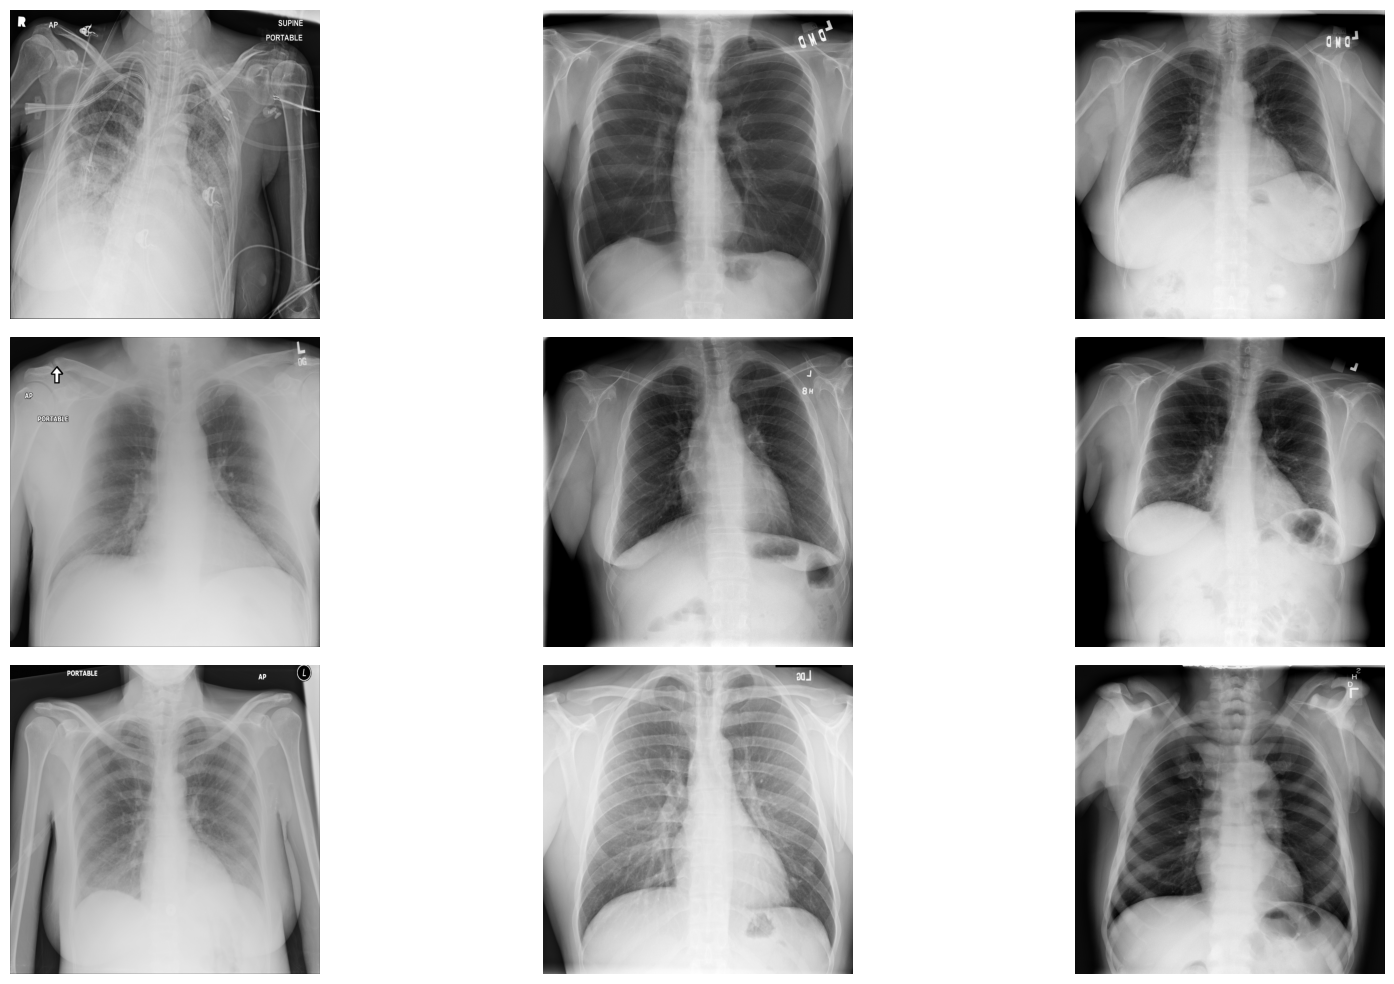


9 görüntü başarıyla görüntülendi.

PROJE ADIMI 4: Seçilen 9 görüntüye sırasıyla işlemlerin uygulanması:.


İŞLEM DÖNGÜSÜ BAŞLANGICI - Görüntü 1: 00026232_040.png

Görüntünün temel istatistiksel özellikleri:
-> Boyutlar: 1024 x 1024
-> Max piksel değeri: 1.0000
-> Min piksel değeri: 0.0000
-> Ortalama piksel değeri: 0.5282
-> Standart sapma: 0.2441

Crop işlemi uygulanıyor...
Kontrast iyileştirme ve histogram eşitleme işlemleri uygulanıyor...
Gürültü azaltma işlemi (Median ve Gaussian) uygulanıyor...
Eşik belirleme yöntemleri için hazırlık yapılıyor...

Thresholding yöntemleri deneniyor...
Otsu için bulunan eşik değeri: 120
Thresholding tamamlandı.

Morfolojik operasyonlar uygulanıyor...
Bağlı bileşen analizi yapılıyor...
Toplam 16 adet nesne (label>0) tespit edildi.
Label 1 ->
   - Area (piksel sayısı): 374174
   - Centroid (x, y)     : (348.60, 593.84)
   - Bounding Box        : x=0, y=0, w=733, h=924
   - Mean Intensity      : 0.76
   - Rectangularity      : 0.5525
Label 2 ->
   - A

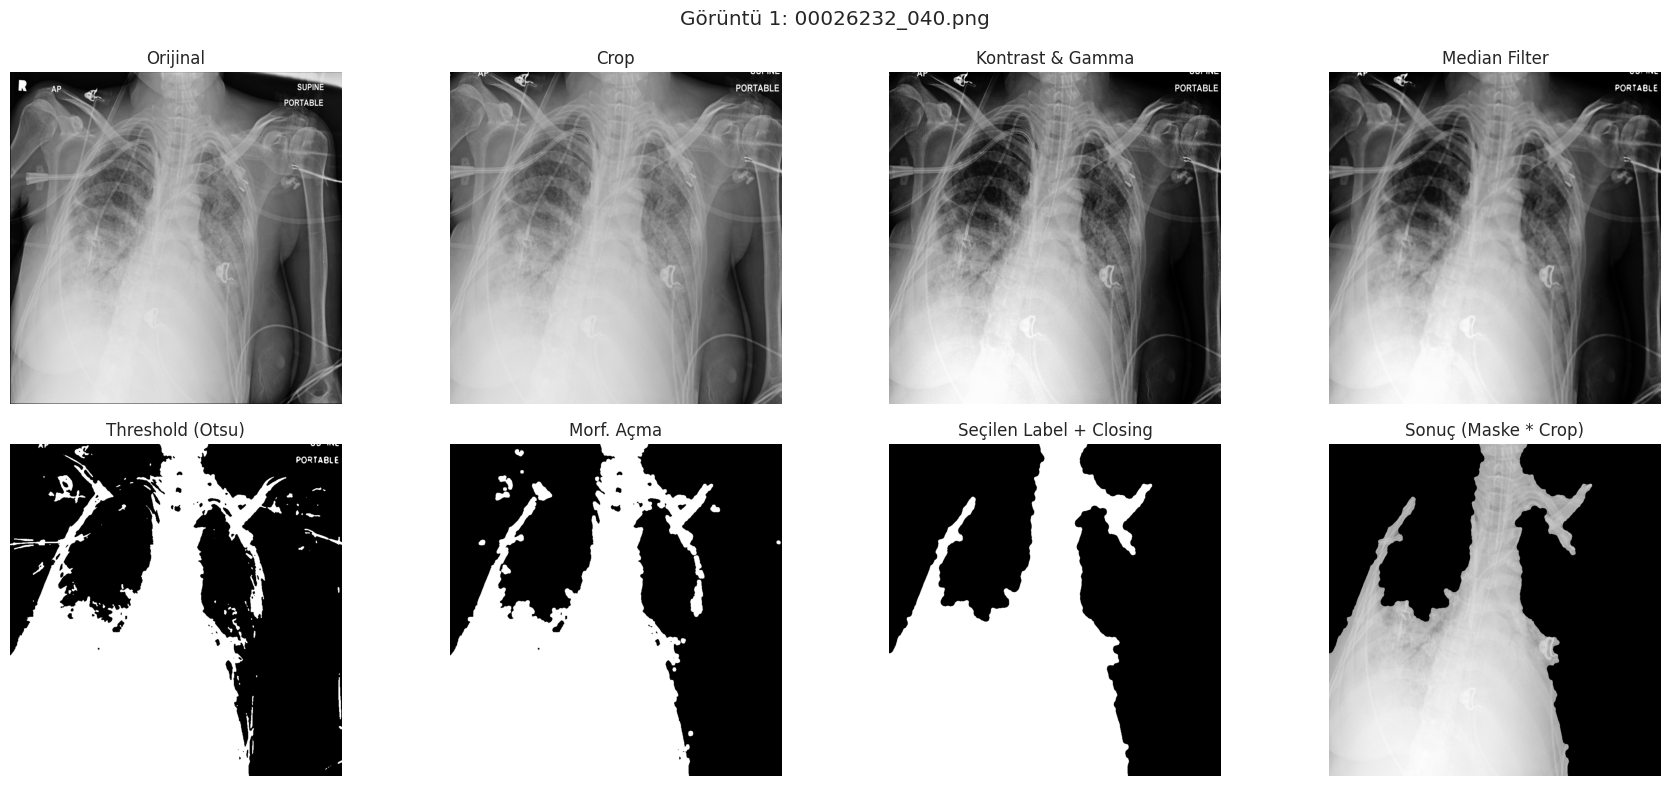

Bu görüntü için işlem döngüsü tamamlandı.
------------------------------------------------------------

İŞLEM DÖNGÜSÜ BAŞLANGICI - Görüntü 2: 00001805_004.png

Görüntünün temel istatistiksel özellikleri:
-> Boyutlar: 1024 x 1024
-> Max piksel değeri: 1.0000
-> Min piksel değeri: 0.0000
-> Ortalama piksel değeri: 0.4300
-> Standart sapma: 0.2143

Crop işlemi uygulanıyor...
Kontrast iyileştirme ve histogram eşitleme işlemleri uygulanıyor...
Gürültü azaltma işlemi (Median ve Gaussian) uygulanıyor...
Eşik belirleme yöntemleri için hazırlık yapılıyor...

Thresholding yöntemleri deneniyor...
Otsu için bulunan eşik değeri: 120
Thresholding tamamlandı.

Morfolojik operasyonlar uygulanıyor...
Bağlı bileşen analizi yapılıyor...
Toplam 9 adet nesne (label>0) tespit edildi.
Label 1 ->
   - Area (piksel sayısı): 388546
   - Centroid (x, y)     : (455.44, 477.97)
   - Bounding Box        : x=0, y=0, w=924, h=924
   - Mean Intensity      : 0.61
   - Rectangularity      : 0.4551
Label 2 ->
   - Area (

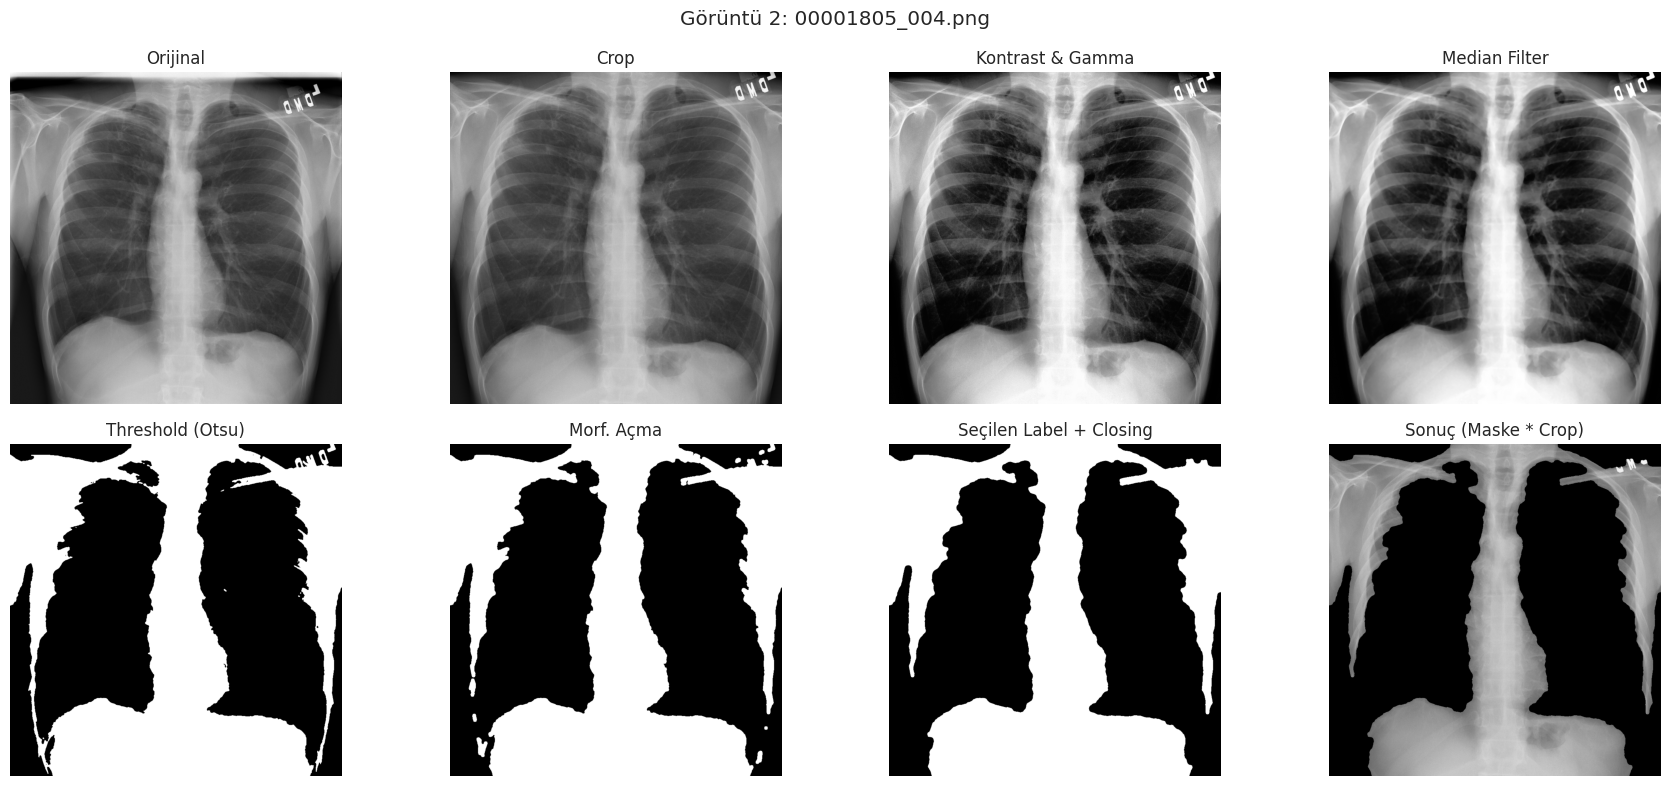

Bu görüntü için işlem döngüsü tamamlandı.
------------------------------------------------------------

İŞLEM DÖNGÜSÜ BAŞLANGICI - Görüntü 3: 00000375_000.png

Görüntünün temel istatistiksel özellikleri:
-> Boyutlar: 1024 x 1024
-> Max piksel değeri: 0.9686
-> Min piksel değeri: 0.0000
-> Ortalama piksel değeri: 0.5258
-> Standart sapma: 0.2681

Crop işlemi uygulanıyor...
Kontrast iyileştirme ve histogram eşitleme işlemleri uygulanıyor...
Gürültü azaltma işlemi (Median ve Gaussian) uygulanıyor...
Eşik belirleme yöntemleri için hazırlık yapılıyor...

Thresholding yöntemleri deneniyor...
Otsu için bulunan eşik değeri: 120
Thresholding tamamlandı.

Morfolojik operasyonlar uygulanıyor...
Bağlı bileşen analizi yapılıyor...
Toplam 10 adet nesne (label>0) tespit edildi.
Label 1 ->
   - Area (piksel sayısı): 112
   - Centroid (x, y)     : (788.49, 44.00)
   - Bounding Box        : x=782, y=39, w=14, h=11
   - Mean Intensity      : 0.87
   - Rectangularity      : 0.7273
Label 2 ->
   - Area (pi

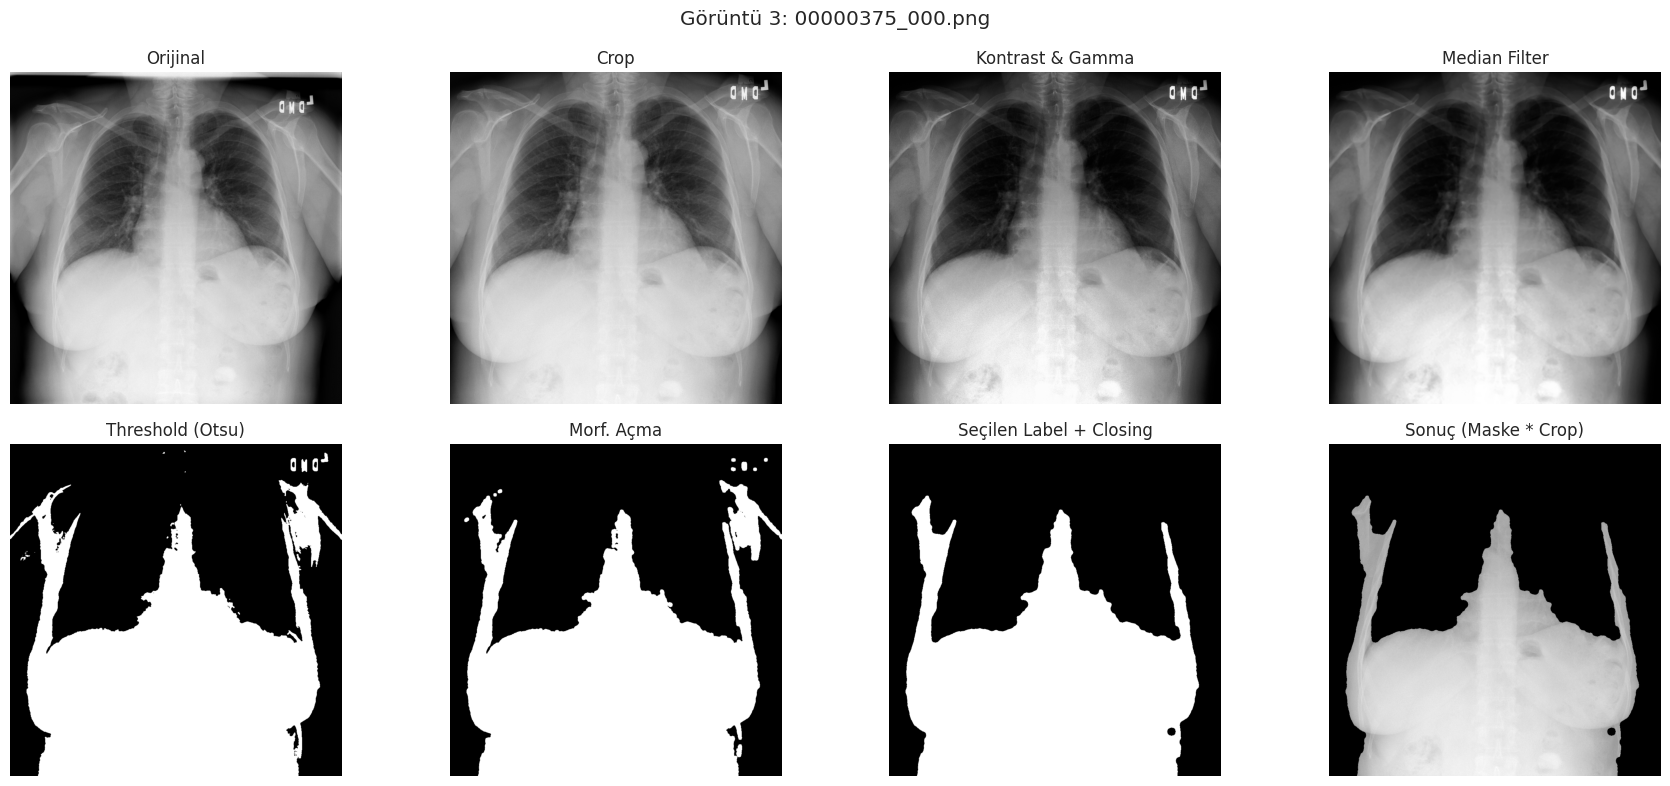

Bu görüntü için işlem döngüsü tamamlandı.
------------------------------------------------------------

İŞLEM DÖNGÜSÜ BAŞLANGICI - Görüntü 4: 00018145_000.png

Görüntünün temel istatistiksel özellikleri:
-> Boyutlar: 1024 x 1024
-> Max piksel değeri: 1.0000
-> Min piksel değeri: 0.0000
-> Ortalama piksel değeri: 0.6200
-> Standart sapma: 0.1834

Crop işlemi uygulanıyor...
Kontrast iyileştirme ve histogram eşitleme işlemleri uygulanıyor...
Gürültü azaltma işlemi (Median ve Gaussian) uygulanıyor...
Eşik belirleme yöntemleri için hazırlık yapılıyor...

Thresholding yöntemleri deneniyor...
Otsu için bulunan eşik değeri: 118
Thresholding tamamlandı.

Morfolojik operasyonlar uygulanıyor...
Bağlı bileşen analizi yapılıyor...
Toplam 6 adet nesne (label>0) tespit edildi.
Label 1 ->
   - Area (piksel sayısı): 52
   - Centroid (x, y)     : (906.50, 1.96)
   - Bounding Box        : x=901, y=0, w=12, h=6
   - Mean Intensity      : 0.81
   - Rectangularity      : 0.7222
Label 2 ->
   - Area (piksel 

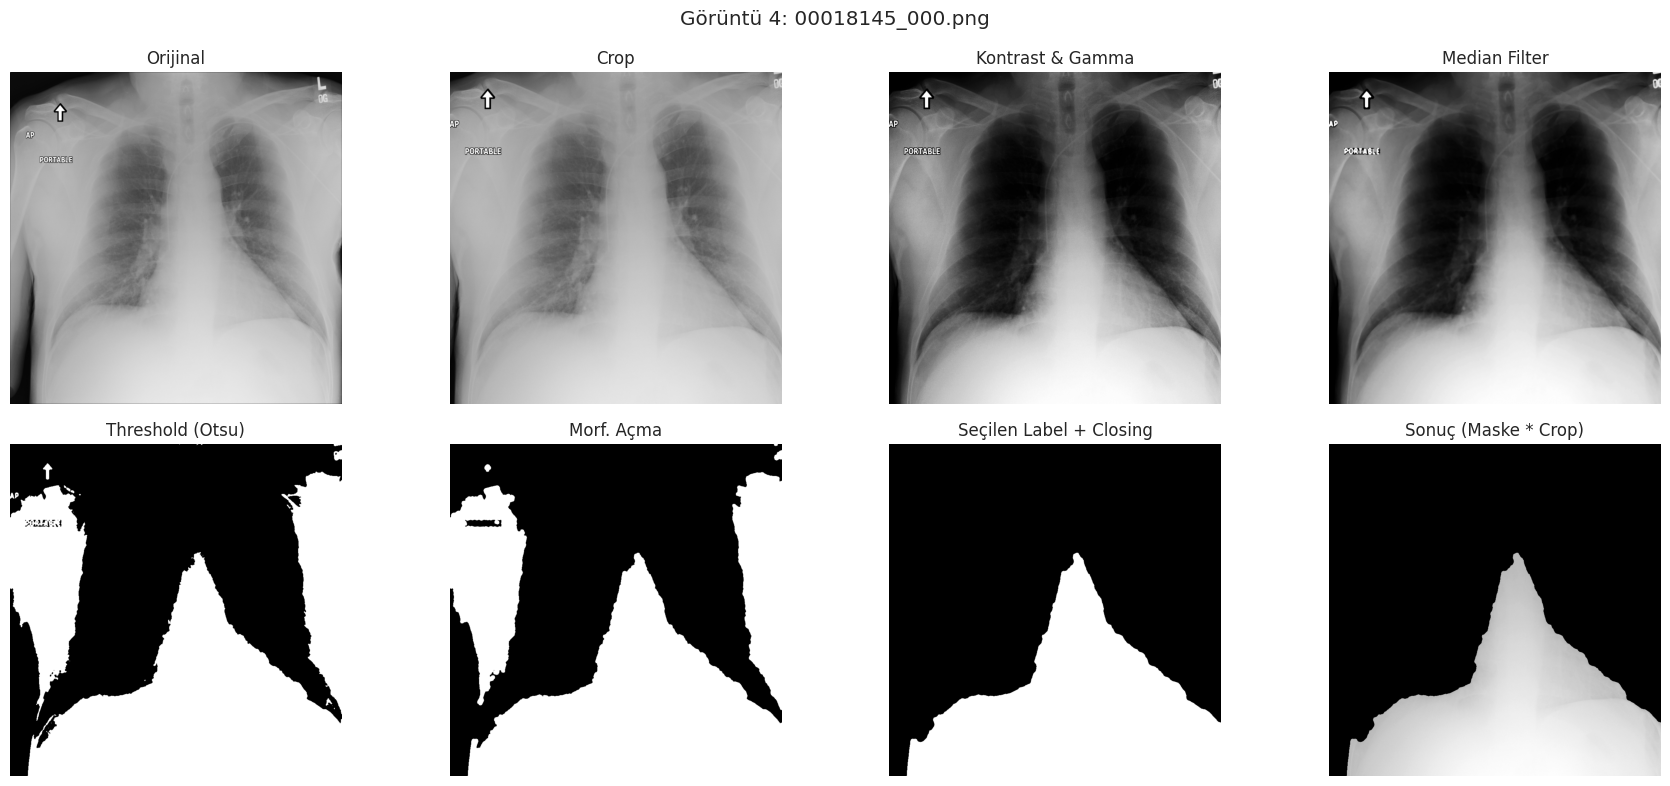

Bu görüntü için işlem döngüsü tamamlandı.
------------------------------------------------------------

İŞLEM DÖNGÜSÜ BAŞLANGICI - Görüntü 5: 00008033_005.png

Görüntünün temel istatistiksel özellikleri:
-> Boyutlar: 1024 x 1024
-> Max piksel değeri: 1.0000
-> Min piksel değeri: 0.0000
-> Ortalama piksel değeri: 0.4790
-> Standart sapma: 0.2570

Crop işlemi uygulanıyor...
Kontrast iyileştirme ve histogram eşitleme işlemleri uygulanıyor...
Gürültü azaltma işlemi (Median ve Gaussian) uygulanıyor...
Eşik belirleme yöntemleri için hazırlık yapılıyor...

Thresholding yöntemleri deneniyor...
Otsu için bulunan eşik değeri: 120
Thresholding tamamlandı.

Morfolojik operasyonlar uygulanıyor...
Bağlı bileşen analizi yapılıyor...
Toplam 5 adet nesne (label>0) tespit edildi.
Label 1 ->
   - Area (piksel sayısı): 385699
   - Centroid (x, y)     : (530.63, 596.92)
   - Bounding Box        : x=87, y=68, w=837, h=856
   - Mean Intensity      : 0.71
   - Rectangularity      : 0.5383
Label 2 ->
   - Area

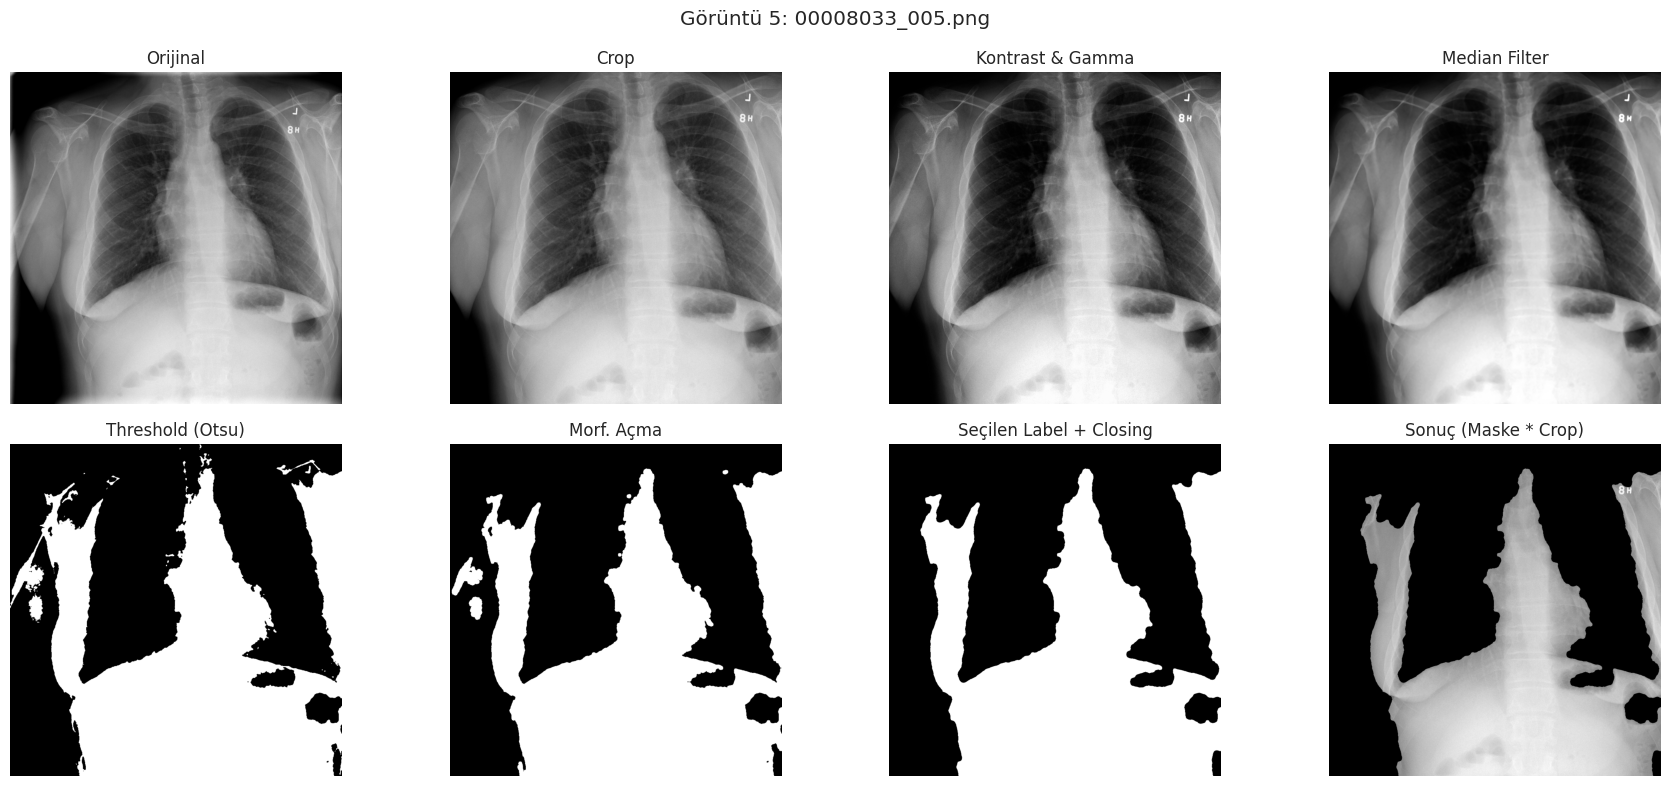

Bu görüntü için işlem döngüsü tamamlandı.
------------------------------------------------------------

İŞLEM DÖNGÜSÜ BAŞLANGICI - Görüntü 6: 00003659_012.png

Görüntünün temel istatistiksel özellikleri:
-> Boyutlar: 1024 x 1024
-> Max piksel değeri: 0.9647
-> Min piksel değeri: 0.0000
-> Ortalama piksel değeri: 0.4825
-> Standart sapma: 0.2918

Crop işlemi uygulanıyor...
Kontrast iyileştirme ve histogram eşitleme işlemleri uygulanıyor...
Gürültü azaltma işlemi (Median ve Gaussian) uygulanıyor...
Eşik belirleme yöntemleri için hazırlık yapılıyor...

Thresholding yöntemleri deneniyor...
Otsu için bulunan eşik değeri: 120
Thresholding tamamlandı.

Morfolojik operasyonlar uygulanıyor...
Bağlı bileşen analizi yapılıyor...
Toplam 5 adet nesne (label>0) tespit edildi.
Label 1 ->
   - Area (piksel sayısı): 120
   - Centroid (x, y)     : (872.70, 55.78)
   - Bounding Box        : x=866, y=50, w=14, h=12
   - Mean Intensity      : 0.69
   - Rectangularity      : 0.7143
Label 2 ->
   - Area (pik

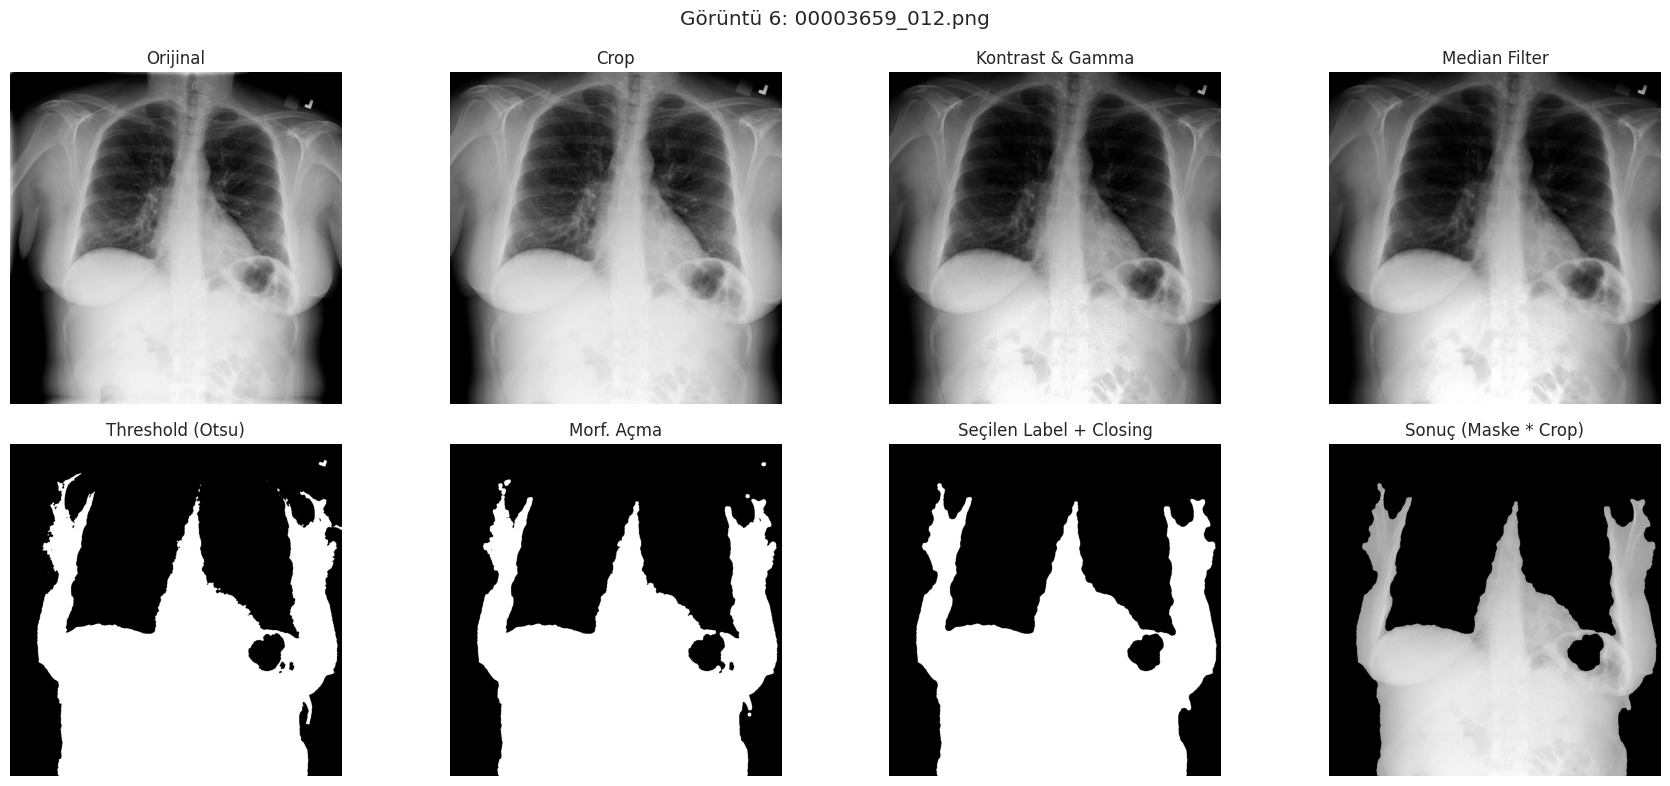

Bu görüntü için işlem döngüsü tamamlandı.
------------------------------------------------------------

İŞLEM DÖNGÜSÜ BAŞLANGICI - Görüntü 7: 00019680_002.png

Görüntünün temel istatistiksel özellikleri:
-> Boyutlar: 1024 x 1024
-> Max piksel değeri: 1.0000
-> Min piksel değeri: 0.0000
-> Ortalama piksel değeri: 0.5953
-> Standart sapma: 0.2093

Crop işlemi uygulanıyor...
Kontrast iyileştirme ve histogram eşitleme işlemleri uygulanıyor...
Gürültü azaltma işlemi (Median ve Gaussian) uygulanıyor...
Eşik belirleme yöntemleri için hazırlık yapılıyor...

Thresholding yöntemleri deneniyor...
Otsu için bulunan eşik değeri: 119
Thresholding tamamlandı.

Morfolojik operasyonlar uygulanıyor...
Bağlı bileşen analizi yapılıyor...
Toplam 14 adet nesne (label>0) tespit edildi.
Label 1 ->
   - Area (piksel sayısı): 391521
   - Centroid (x, y)     : (470.01, 554.90)
   - Bounding Box        : x=0, y=0, w=852, h=924
   - Mean Intensity      : 0.76
   - Rectangularity      : 0.4973
Label 2 ->
   - Area 

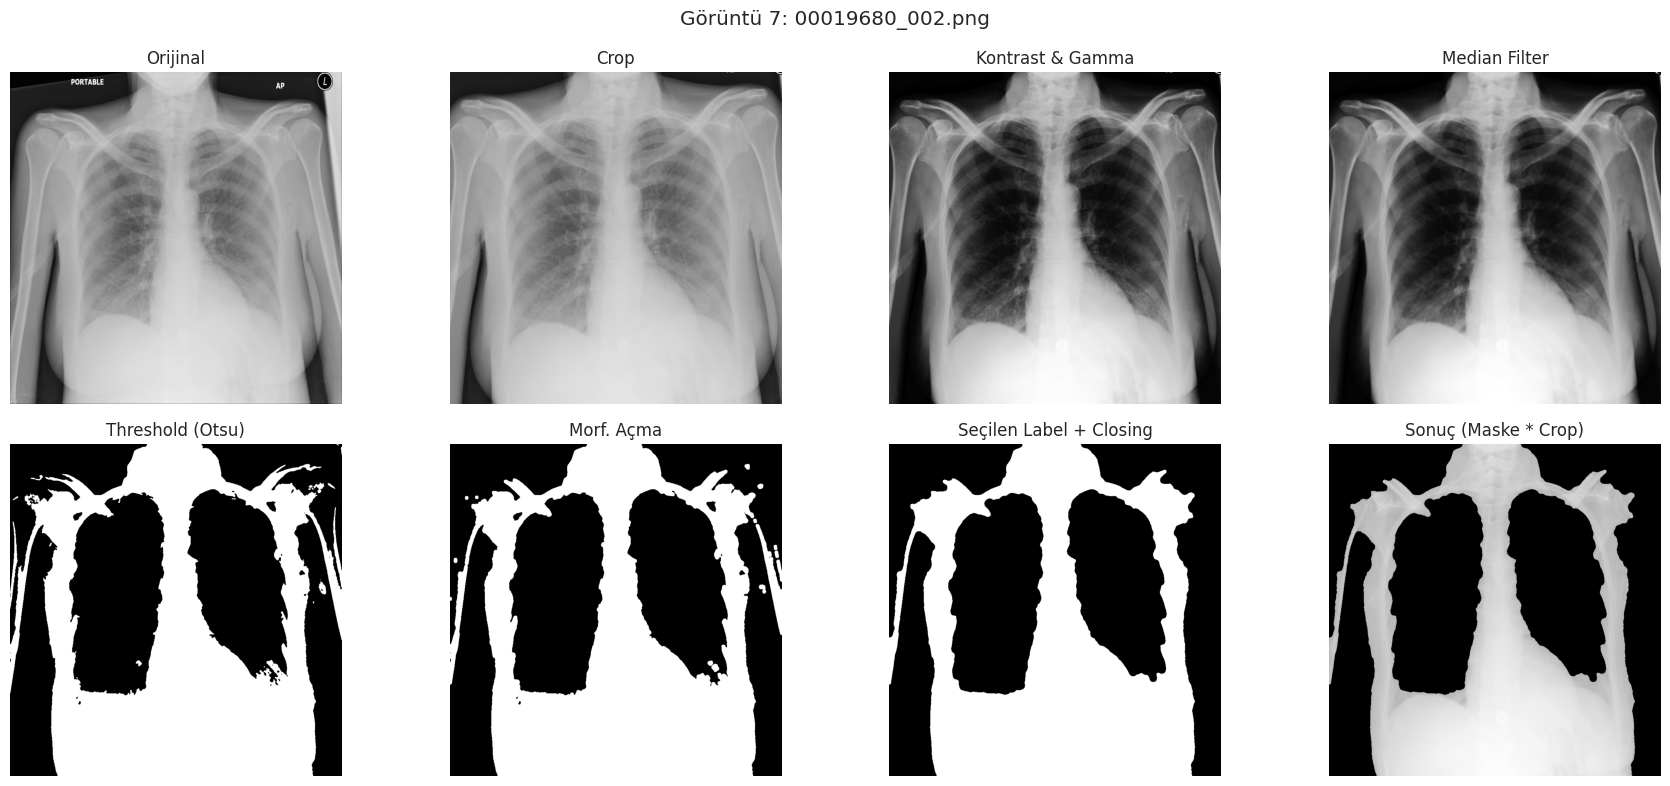

Bu görüntü için işlem döngüsü tamamlandı.
------------------------------------------------------------

İŞLEM DÖNGÜSÜ BAŞLANGICI - Görüntü 8: 00006360_000.png

Görüntünün temel istatistiksel özellikleri:
-> Boyutlar: 1024 x 1024
-> Max piksel değeri: 0.9059
-> Min piksel değeri: 0.0000
-> Ortalama piksel değeri: 0.6388
-> Standart sapma: 0.1669

Crop işlemi uygulanıyor...
Kontrast iyileştirme ve histogram eşitleme işlemleri uygulanıyor...
Gürültü azaltma işlemi (Median ve Gaussian) uygulanıyor...
Eşik belirleme yöntemleri için hazırlık yapılıyor...

Thresholding yöntemleri deneniyor...
Otsu için bulunan eşik değeri: 119
Thresholding tamamlandı.

Morfolojik operasyonlar uygulanıyor...
Bağlı bileşen analizi yapılıyor...
Toplam 12 adet nesne (label>0) tespit edildi.
Label 1 ->
   - Area (piksel sayısı): 249114
   - Centroid (x, y)     : (500.85, 653.70)
   - Bounding Box        : x=107, y=0, w=776, h=924
   - Mean Intensity      : 0.78
   - Rectangularity      : 0.3474
Label 2 ->
   - Are

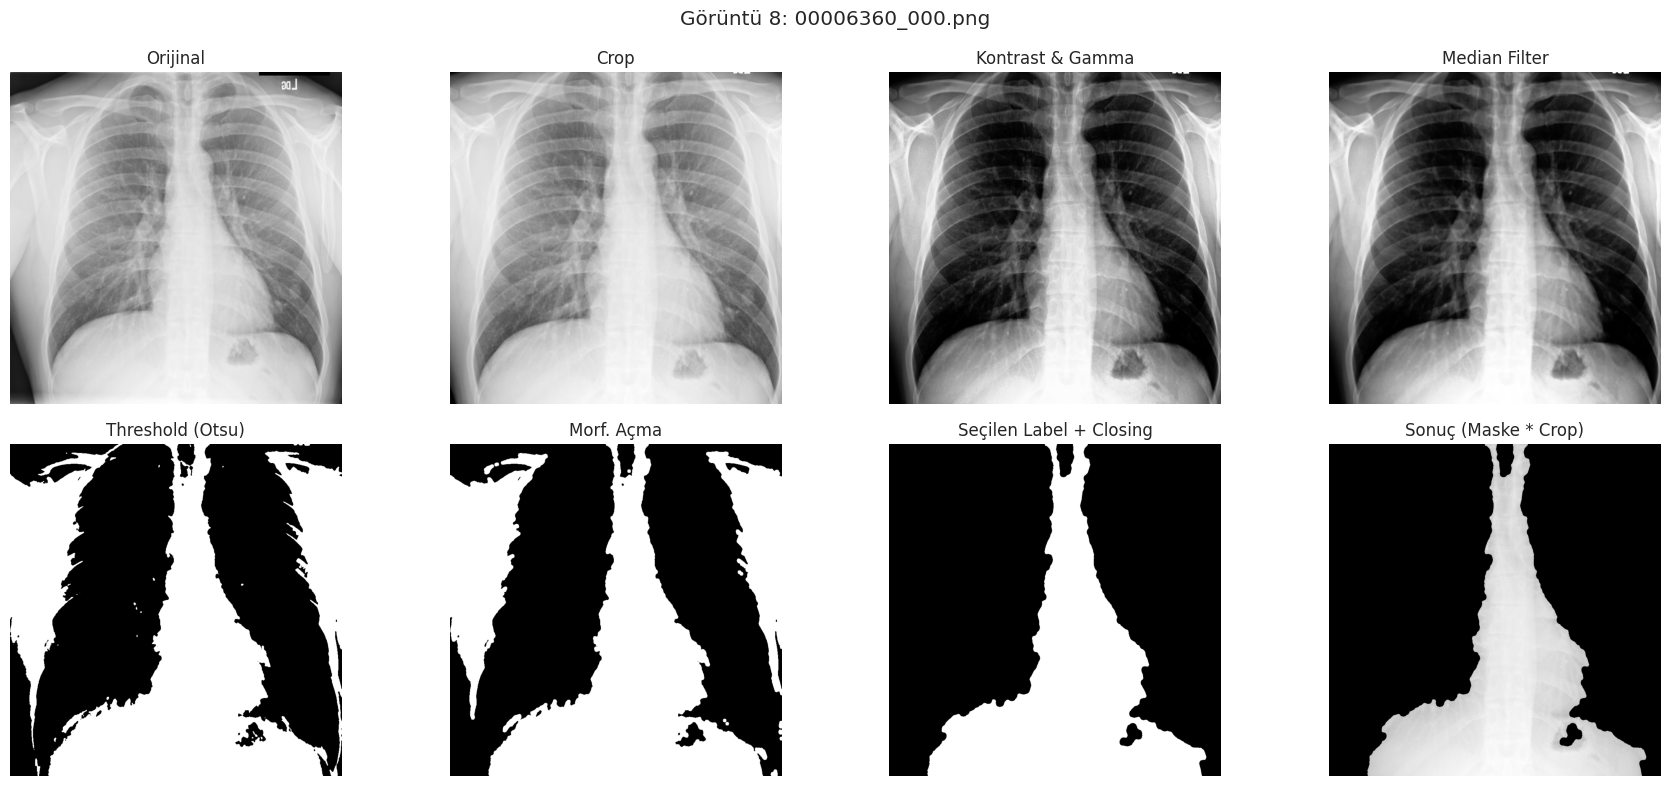

Bu görüntü için işlem döngüsü tamamlandı.
------------------------------------------------------------

İŞLEM DÖNGÜSÜ BAŞLANGICI - Görüntü 9: 00013592_019.png

Görüntünün temel istatistiksel özellikleri:
-> Boyutlar: 1024 x 1024
-> Max piksel değeri: 1.0000
-> Min piksel değeri: 0.0000
-> Ortalama piksel değeri: 0.4467
-> Standart sapma: 0.2526

Crop işlemi uygulanıyor...
Kontrast iyileştirme ve histogram eşitleme işlemleri uygulanıyor...
Gürültü azaltma işlemi (Median ve Gaussian) uygulanıyor...
Eşik belirleme yöntemleri için hazırlık yapılıyor...

Thresholding yöntemleri deneniyor...
Otsu için bulunan eşik değeri: 119
Thresholding tamamlandı.

Morfolojik operasyonlar uygulanıyor...
Bağlı bileşen analizi yapılıyor...
Toplam 8 adet nesne (label>0) tespit edildi.
Label 1 ->
   - Area (piksel sayısı): 245721
   - Centroid (x, y)     : (458.52, 641.45)
   - Bounding Box        : x=53, y=0, w=817, h=924
   - Mean Intensity      : 0.71
   - Rectangularity      : 0.3255
Label 2 ->
   - Area 

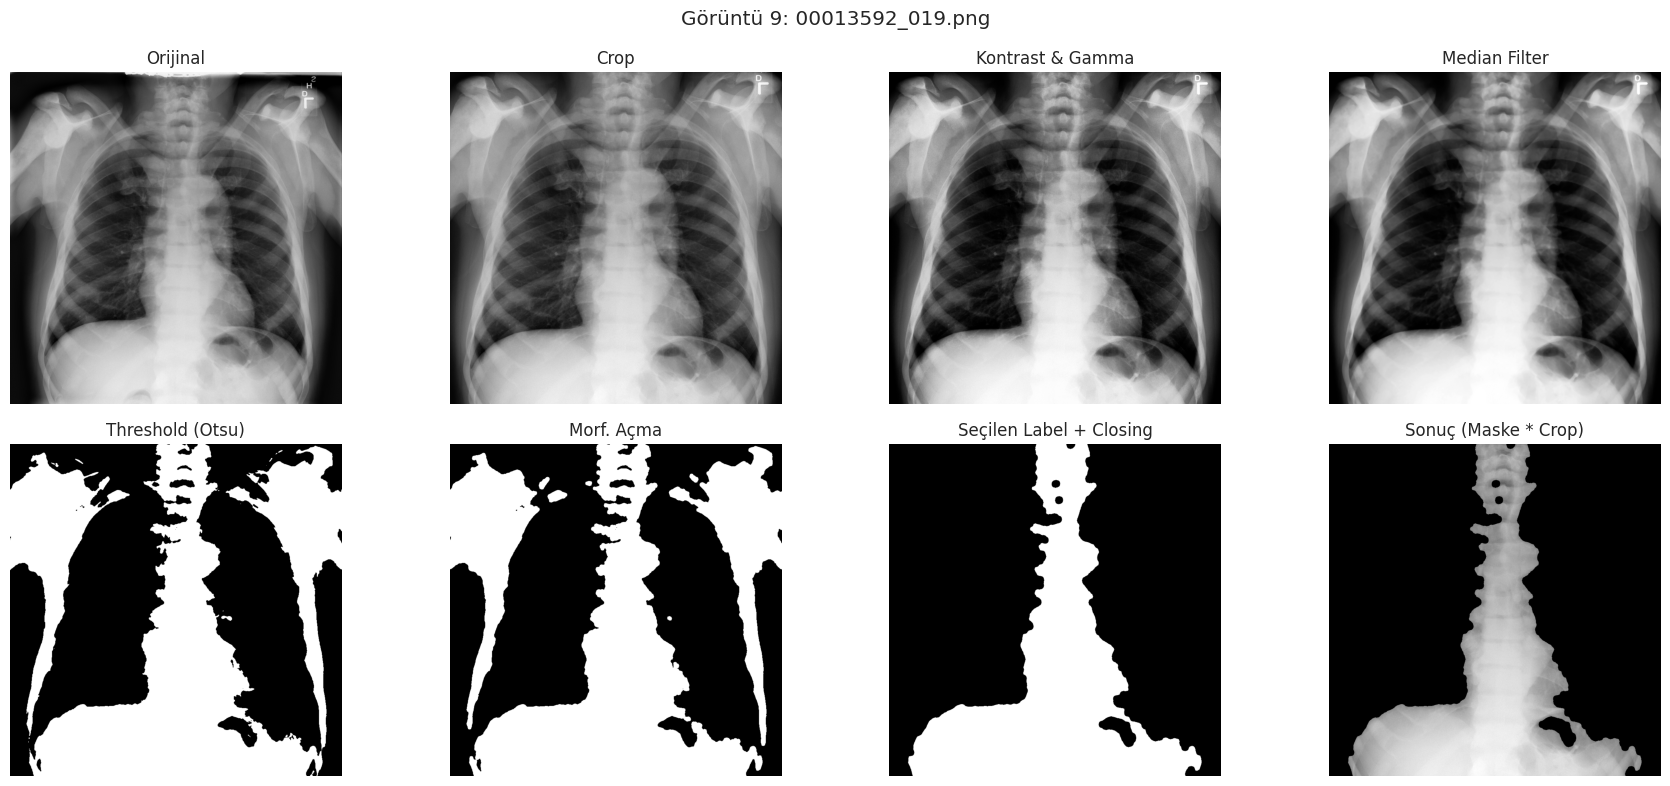

Bu görüntü için işlem döngüsü tamamlandı.
------------------------------------------------------------

Tüm 9 görüntü için işlem başarıyla tamamlanmıştır.
Proje Sonu: Elde edilen maskeler ve nihai sonuçlar gösterildi.



In [2]:
#############################################################################
# 3) 9 Rastgele Görsel Seçilmesi ve Görselleştirilmesi
#############################################################################
print("\nPROJE ADIMI 3: Rastgele 9 görsel seçerek verisetinden örnekler gösterelim.\n")

images = train_df['Image'].values
# 9 rastgele görüntü seçilmesi:
random_images = [np.random.choice(images) for i in range(9)]
img_dir = 'nih/images_small/'

print("Rastgele seçilmiş 9 görüntü:")
plt.figure(figsize=(18, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()
print("\n9 görüntü başarıyla görüntülendi.\n")


#############################################################################
# Tüm İşlemleri 9 Görüntü Üzerinde Adım Adım Uygulama
#############################################################################
print("PROJE ADIMI 4: Seçilen 9 görüntüye sırasıyla işlemlerin uygulanması:.\n")


def crop_image(image, border=50):
    """
    Basitçe kenarlardan belirli pikselleri kırparak
    akciğer bölgeleri korunmaya çalışılır.
    border değeri kadar 4 yandan kesme yapılır.
    """
    h, w = image.shape
    cropped = image[border:h-border, border:w-border]
    return cropped

for idx in range(9):
    print(f"\n{'='*60}")
    print(f"İŞLEM DÖNGÜSÜ BAŞLANGICI - Görüntü {idx+1}: {random_images[idx]}")
    print(f"{'='*60}\n")

    #-----------------------------------------------------------------------
    # 1) Görseli Oku
    #-----------------------------------------------------------------------
    raw_image = plt.imread(os.path.join(img_dir, random_images[idx]))

    #-----------------------------------------------------------------------
    # İstatistiksel özelliklerini hesaplayalım
    #-----------------------------------------------------------------------
    print("Görüntünün temel istatistiksel özellikleri:")
    print(f"-> Boyutlar: {raw_image.shape[0]} x {raw_image.shape[1]}")
    print(f"-> Max piksel değeri: {raw_image.max():.4f}")
    print(f"-> Min piksel değeri: {raw_image.min():.4f}")
    print(f"-> Ortalama piksel değeri: {raw_image.mean():.4f}")
    print(f"-> Standart sapma: {raw_image.std():.4f}\n")

    #-----------------------------------------------------------------------
    # 2) Kırpma (Crop) işlemi
    #-----------------------------------------------------------------------
    print("Crop işlemi uygulanıyor...")
    cropped = crop_image(raw_image, border=50)

    #-----------------------------------------------------------------------
    # 3) Kontrast Germe (Stretching) ve Histogram Eşitleme
    #    (İstenen dönüşümlerden birini veya birkaçını uygulayabiliriz.)
    #-----------------------------------------------------------------------
    print("Kontrast iyileştirme ve histogram eşitleme işlemleri uygulanıyor...")
    min_val, max_val = cropped.min(), cropped.max()
    # Kontrast germe
    stretched = (cropped - min_val) / (max_val - min_val + 1e-8)
    stretched = (stretched * 255).astype(np.uint8)
    # Histogram Eşitleme
    eq_img = exposure.equalize_hist(stretched)
    eq_img = (eq_img * 255).astype(np.uint8)
    # Gamma dönüşümü
    gamma = 1.2
    gamma_corrected = np.power(eq_img / 255.0, gamma) * 255
    gamma_corrected = gamma_corrected.astype(np.uint8)

    #-----------------------------------------------------------------------
    # 4) Gürültü Azaltma (Median veya Gaussian Blur)
    #-----------------------------------------------------------------------
    print("Gürültü azaltma işlemi (Median ve Gaussian) uygulanıyor...")
    median_filtered = cv2.medianBlur(gamma_corrected, 5)
    gaussian_filtered = cv2.GaussianBlur(gamma_corrected, (5, 5), 0)

    # Burada, bir sonraki adım için median filtre sonuçlarını kullanacağız:
    processed_for_threshold = median_filtered.copy()

    #-----------------------------------------------------------------------
    # 5) Eşik Sayısı Belirleme (Bu aşamada genellikle hangi eşik yöntemini
    #    uygulayacağımızı planlarız. Tek eşik veya çoklu eşik.)
    #-----------------------------------------------------------------------
    print("Eşik belirleme yöntemleri için hazırlık yapılıyor...\n")

    #-----------------------------------------------------------------------
    # 6) Thresholding (Global, Otsu vs. skimage try_all_threshold)
    #-----------------------------------------------------------------------
    print("Thresholding yöntemleri deneniyor...")

    # "try_all_threshold" ile farklı eşikleri hızlıca deneyebiliriz.
    # Ancak görselleştirme çok yer kaplayacağından, direkt Otsu ve sabit global threshold karşılaştıralım.
    otsu_val = threshold_otsu(processed_for_threshold)
    _, global_thresh = cv2.threshold(processed_for_threshold, 127, 255, cv2.THRESH_BINARY)

    # Otsu Threshold
    otsu_binary = (processed_for_threshold >= otsu_val).astype(np.uint8) * 255

    # Tercihen Otsu yöntemi daha iyi sonuç veriyorsa onu seçelim.
    binary_img = otsu_binary.copy()

    print(f"Otsu için bulunan eşik değeri: {otsu_val}")
    print("Thresholding tamamlandı.\n")

    #-----------------------------------------------------------------------
    # 7) Post-Processing
    #    (Morfolojik Operatörler, Connected Components, Filtreleme vb.)
    #-----------------------------------------------------------------------
    print("Morfolojik operasyonlar uygulanıyor...")

    # Açma (Opening) ile ufak gürültüleri temizleyelim
    selem = disk(5)
    # OpenCV ile de yapabiliriz ancak skimage'in disk() ile kolay
    # struct elem tanımlaması yapabiliyoruz.
    # opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
    # skimage versiyonunu kullanalım
    import skimage.morphology as mph
    opened = mph.opening(binary_img, selem)

    print("Bağlı bileşen analizi yapılıyor...")
    # Burada OpenCV'nin connectedComponents fonksiyonunu kullanalım
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened, connectivity=8)

    print(f"Toplam {num_labels-1} adet nesne (label>0) tespit edildi.")
    # stats: [label, x, y, width, height, area] -> OpenCV docs
    # shape: (num_labels, 5)
    # 0. index arkaplan (label=0), geriye kalanlar objectler

    # Her region için en az 5 öznitelik: Area, MeanIntensity, vb.
    # Orijinal (veya gri ölçekteki) piksellerden de intensities alınabilir.
    # Basitçe alan ve centroid değerlerini yazdıralım.
    # (Daha fazla öznitelik için scikit-image regionprops daha uygun)
    gray_for_props = cropped.copy()

    for label_id in range(1, num_labels):
        x = stats[label_id, cv2.CC_STAT_LEFT]
        y = stats[label_id, cv2.CC_STAT_TOP]
        w = stats[label_id, cv2.CC_STAT_WIDTH]
        h = stats[label_id, cv2.CC_STAT_HEIGHT]
        area = stats[label_id, cv2.CC_STAT_AREA]
        cx, cy = centroids[label_id]

        # 1) Area
        # 2) Centroid
        # 3) Bounding Box (sol-üst ve genişlik-yükseklik)
        # 4) Mean Intensity (maskelenmiş piksel ortalaması)
        # 5) Rectangularity = Alan / (w*h)

        region_mask = (labels == label_id)
        mean_intensity = np.mean(gray_for_props[region_mask])

        rectangularity = area / (w * h + 1e-8)

        print(f"Label {label_id} ->")
        print(f"   - Area (piksel sayısı): {area}")
        print(f"   - Centroid (x, y)     : ({cx:.2f}, {cy:.2f})")
        print(f"   - Bounding Box        : x={x}, y={y}, w={w}, h={h}")
        print(f"   - Mean Intensity      : {mean_intensity:.2f}")
        print(f"   - Rectangularity      : {rectangularity:.4f}")
    print("--------------------------------------------------")

    print("\nÖznitelikler incelendikten sonra, akciğer alanını temsil eden label(lar) filtrelenebilir.\n"
          "Basitçe en büyük alanlara sahip 2 label'ı seçeceğiz (örn. akciğerler) veya 1 en büyük label.\n")

    # Sıralama: alan büyükten küçüğe
    label_areas = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)]
    label_areas.sort(key=lambda x: x[1], reverse=True)

    # Biz en büyük label'ı alalım
    if len(label_areas) > 0:
        lung_label = label_areas[0][0]
    else:
        lung_label = 0

    # Filtrelenmiş maske: Yalnızca seçtiğimiz label
    filtered_mask = np.zeros_like(opened, dtype=np.uint8)
    filtered_mask[labels == lung_label] = 255

    # Ek bir morfolojik işlem yapalım (closing)
    filtered_mask = mph.closing(filtered_mask, disk(10))

    #-----------------------------------------------------------------------
    # 8) Sonuç Görüntüsünün Oluşturulması (Maske * Orijinal)
    #-----------------------------------------------------------------------
    # Not: Orijinal boyut croplanmışa göre farklı. Crop üstünde mask çalıştık,
    # Bu örnekte cropped görselimiz ile maskeyi çarpabiliriz.
    # Dönüş boyutlarını eşitlemek açısından, basitçe processed boyutta sonuç gösteriyoruz.
    print("Son maske ile orijinal kırpılmış görüntü çarpılarak sonuç elde ediliyor...\n")
    final_result = cv2.bitwise_and(cropped, cropped, mask=filtered_mask)

    #-----------------------------------------------------------------------
    # Görselleştirme: Adım Adım Göstermek
    #-----------------------------------------------------------------------
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))
    axes[0,0].imshow(raw_image, cmap='gray')
    axes[0,0].set_title("Orijinal")
    axes[0,0].axis('off')

    axes[0,1].imshow(cropped, cmap='gray')
    axes[0,1].set_title("Crop")
    axes[0,1].axis('off')

    axes[0,2].imshow(gamma_corrected, cmap='gray')
    axes[0,2].set_title("Kontrast & Gamma")
    axes[0,2].axis('off')

    axes[0,3].imshow(median_filtered, cmap='gray')
    axes[0,3].set_title("Median Filter")
    axes[0,3].axis('off')

    axes[1,0].imshow(binary_img, cmap='gray')
    axes[1,0].set_title("Threshold (Otsu)")
    axes[1,0].axis('off')

    axes[1,1].imshow(opened, cmap='gray')
    axes[1,1].set_title("Morf. Açma")
    axes[1,1].axis('off')

    axes[1,2].imshow(filtered_mask, cmap='gray')
    axes[1,2].set_title("Seçilen Label + Closing")
    axes[1,2].axis('off')

    axes[1,3].imshow(final_result, cmap='gray')
    axes[1,3].set_title("Sonuç (Maske * Crop)")
    axes[1,3].axis('off')

    plt.suptitle(f"Görüntü {idx+1}: {random_images[idx]}")
    plt.tight_layout()
    plt.show()

    print("Bu görüntü için işlem döngüsü tamamlandı.")
    print("-"*60)


print("\nTüm 9 görüntü için işlem başarıyla tamamlanmıştır.")
print("Proje Sonu: Elde edilen maskeler ve nihai sonuçlar gösterildi.\n")


# **Görüntü İşleme Sonuçlarının Değerlendirilmesi**

Bu projede, ChestX-ray8 veri setinden rastgele seçilen 9 göğüs röntgeni görüntüsü üzerinde sırasıyla şu adımlar uygulanmıştır:

1. **Kırpma (Crop) İşlemi**  
   - Kenarlardan belirli bir `border` (örnek: 50 piksel) değeri kadar kesilerek, röntgenlerdeki etiketten veya çevresel gürültüden kurtulmak amaçlanmıştır.  
   - Kırpma, akciğerlerin bulunduğu asıl ilgi alanını (ROI) mümkün olduğunca korurken, sonraki işlemlerde hesap yükünü de azaltır.  
   - Bazı röntgenlerde ufak kenar bölgelerinin kırpılması yeterli olup, fazla agresif kırpma akciğer dokusunun bir bölümünü kesme riskini taşır.

2. **Kontrast Germe (Stretching) ve Histogram Eşitleme (Equalization)**  
   - Kırpılan görüntülerin dinamik aralığını genişletmek (stretching) ve piksellerin dağılımını dengelemek (histogram eşitleme) için çeşitli dönüşümler uygulanmıştır.  
   - Özellikle **Histogram Eşitleme**, göğüs röntgeninde karanlık bölgeleri daha görünür hale getirirken, parlak bölgelerin de doygunluk seviyesini dengeleyerek klinik olarak önemli detayları ön plana çıkarabilir.  
   - Ek olarak, **Gamma Düzeltme (gamma = 1.2)** kullanılarak parlaklık algısı iyileştirilmiştir. Bu tür ek bir düzeltme, radyolojik incelemede ince doku farklılıklarının belirginliğini artırabilir.

3. **Gürültü Azaltma (Median ve Gaussian Blur)**  
   - Kontrast iyileştirme adımlarının ardından, segmentasyon kalitesini artırmak amacıyla **Median** ve **Gaussian** filtreler denenmiştir.  
   - Kodda sonraki aşamalarda (eşikleme gibi) kullanılmak üzere **Median** filtre sonucu tercih edilmiştir. Median filtre, “tuz ve biber” tipi gürültüye karşı etkilidir ve kenar korunmasında Gaussian’a göre avantaj sağlayabilir.  
   - Farklı çekirdek boyutları (örn. 3×3 veya 5×5) denemek görüntüdeki gürültü seviyesine göre daha iyi sonuçlar verebilir.

4. **Eşik Belirleme (Thresholding) – Global ve Otsu**  
   - Projede sabit bir global eşik (127) ile **Otsu** yöntemi karşılaştırılmış; Otsu yöntemi piksel dağılımına göre otomatik en iyi eşik değerini hesaplamıştır.  
   - Çıktılara bakıldığında, Otsu yönteminin bulduğu eşik değerleri (`otsu_val = 119` veya `120` vb.) çoğunlukla sabit 127’den daha uyumlu sonuçlar vermiştir.  
   - Çoklu eşik (`threshold_multiotsu`) veya farklı yöntemleri (`try_all_threshold`) de deneyerek, akciğer, yumuşak doku ve kemik gibi bölgeleri ayrı ayrı segmentlemek mümkün olabilir.

5. **Morfolojik İşlemler (Açma/Opening, Kapama/Closing)**  
   - Eşiklenmiş maskede küçük gürültü parçalarını yok etmek için **Opening** (Açma) uygulanmıştır. Ardından, seçilen label’ı daha bütün hale getirmek amacıyla **Closing** (Kapama) işlemi gerçekleştirilmiştir.  
   - Morfolojik işlemler, medikal görüntülerde segmentasyon sonrası “delikleri doldurmak” (closing) veya “küçük parçaları silmek” (opening) için sıkça kullanılır.

6. **Bağlı Bileşen Analizi (Connected Components)**  
   - İşlenmiş binary maske üzerinden **cv2.connectedComponentsWithStats** fonksiyonu ile her bir bağlı bileşenin alan, centroid, bounding box, ortalama yoğunluk (mean intensity), dikdörtgensellik (rectangularity) gibi öznitelikleri çıkarılmıştır.  
   - Her görüntüde çoğu zaman en büyük veya en büyük iki bileşen potansiyel olarak akciğerleri temsil etmektedir. “İki taraflı akciğer segmentasyonu” tipik yaklaşımdır, fakat bu proje akışında örnek olarak “en büyük label” seçimi yapılmıştır.

7. **Filtrelenmiş Maskenin Orijinal (Kırpılmış) Görüntüyle Çarpılması**  
   - Son adımda, seçilen (veya birleştirilen) label üzerinden oluşturulan maske, kırpılmış görüntüyle çarpılmıştır (**bitwise_and**). Böylece **ilgi alanı dışındaki** piksellerin sıfırlandığı ve yalnızca akciğer bölgesinin netleştirildiği bir sonuç görüntü elde edilmektedir.

---

## **Genel Gözlemler ve Sonuçlar**

- **Crop** ve **Gürültü Azaltma** adımları, segmentasyon kalitesine gözle görülür biçimde katkı sağlamış; kenar ve etiket gürültüleri büyük oranda temizlenmiştir.  
- **Kontrast ve Histogram Eşitleme** sayesinde, göğüs röntgeni üzerindeki koyu ve açık bölgeler dengelenmiş, potansiyel lezyon veya doku farklılıklarının belirginleşmesi sağlanmıştır.  
- **Otsu Eşiklemesi**, her görüntüde ortalama olarak daha tutarlı ikili maske oluşturmuş; sabit global eşik yaklaşımına kıyasla manuel parametre ayarlama gereksinimini azaltmıştır.  
- **Morfolojik Açma ve Kapama** aşamaları, maske üzerinde küçük parçacıkları yok ederek ve boşlukları doldurarak, akciğer alanını daha bütünsel bir şekilde ortaya çıkarmıştır.  
- **Bağlı Bileşen Analizi** ile farklı bölgelerin alan, konum, yoğunluk gibi özellikleri incelenerek “akciğer” olarak değerlendirilebilecek en büyük veya en uygun bileşen(ler) seçilmiştir.

Bu süreç sonunda elde edilen görüntülerde, **akciğer bölgelerinin** belirgin bir şekilde segmentasyonunun yapıldığı ve maske üzerinden orijinal görüntünün vurgulandığı görülmüştür. İstenirse “iki akciğer” bilgisini ayrı ayrı yakalamak veya çoklu eşik seviyeleriyle daha detaylı bölgeleri ayırmak mümkündür.  

**Sonuç olarak**, proje adımları göğüs röntgenlerinin temel segmentasyon sürecini özetlemekte; tıbbi görüntü işleme projelerinde sıkça kullanılan kırpma, histogram eşitleme, gürültü azaltma, thresholding, morfolojik operasyonlar ve bağlı bileşen analizinin entegrasyonunu göstermektedir.
